In [24]:
# !pip install -U langgraph langsmith

In [25]:
!pip install dotenv

In [26]:
from dotenv import load_dotenv
load_dotenv()
import os

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
print(MISTRAL_API_KEY)

9p4IjQS69avXaFnaDnb5AoFiTLwiN0Zh


In [27]:
!pip install langchain_ollama langchain_nomic langchain_mistralai

In [28]:
from langchain_ollama import OllamaEmbeddings
from langchain_nomic import NomicEmbeddings
from langchain_mistralai import ChatMistralAI

# For the embedding we, are going to use OllamaEmbeddings with the nomic-embed-text model
# This model is a 7B model that is trained to embed text
embeddings = OllamaEmbeddings(
    model="nomic-embed-text"
)


In [29]:
mistral_model = ChatMistralAI(model="mistral-large-latest", temperature=0, api_key=MISTRAL_API_KEY)

In [30]:
import psycopg2

class CockroachDBAgent:
    def __init__(self, connection_string):
        """Initialize with a connection string"""
        self.connection_string = connection_string
        self.connection =  self.connect()
        self.cursor = None
    
    def connect(self):
        """Establish a connection using the connection string"""
        try:
            self.connection = psycopg2.connect(self.connection_string)
            self.cursor = self.connection.cursor()
            print("Connected to CockroachDB successfully!")
        except Exception as e:
            print(f"Error: Unable to connect to the database: {e}")
    
    def insert_candidate(self,first_name, last_name, description):
        """Insert a new candidate into the database"""
        try:
            self.cursor.execute(
                """
                INSERT INTO HRCandidates(description, first_name, last_name)
                VALUES (%s, %s, %s)
                """,
                (description, first_name, last_name)
            )
            self.connection.commit()
            print(f"Candidate inserted successfully!")
        except Exception as e:
            print(f"Error inserting candidate: {e}")
    
    def get_candidates(self):
        """Fetch and return all candidates from the database"""
        try:
            self.cursor.execute("SELECT * FROM HRCandidates")
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            print(f"Error fetching candidates: {e}")
            return []

    def delete_candidate(self, candidate_id):
        """Delete a candidate from the database by ID"""
        try:
            self.cursor.execute(
                """
                DELETE FROM HRCandidates
                WHERE id = %s
                """,
                (candidate_id,)
            )
            self.connection.commit()
            print(f"Candidate with ID {candidate_id} deleted successfully!")
        except Exception as e:
            print(f"Error deleting candidate: {e}")
            
    def print_candidates(self):
        """Print the candidate data fetched from the database"""
        rows = self.get_candidates()
        for count, row in enumerate(rows):
            print("Canidate: ", count, "Information: ", row)
    
    def close(self):
        """Close the connection to the database"""
        if self.cursor:
            self.cursor.close()
        if self.connection:
            self.connection.close()
        print("Connection closed.")
        
    def as_retriver(self): 
        return self



In [31]:
# Developing the agent itself

CockroachDBAgent = CockroachDBAgent(os.getenv("DATABASE_URL"))

Error: Unable to connect to the database: root certificate file "/Users/mitanshgor/.postgresql/root.crt" does not exist
Either provide the file or change sslmode to disable server certificate verification.



In [32]:
CockroachDBAgent.connect()
as_retriever = CockroachDBAgent.as_retriver()

Error: Unable to connect to the database: root certificate file "/Users/mitanshgor/.postgresql/root.crt" does not exist
Either provide the file or change sslmode to disable server certificate verification.



In [33]:
as_retriever.print_candidates()

Error fetching candidates: 'NoneType' object has no attribute 'execute'


In [34]:
as_retriever.delete_candidate(1067964395977768961)

Error deleting candidate: 'NoneType' object has no attribute 'execute'


In [35]:
# The cells bellow are the tools taht will be used for the application itself

In [36]:

def insert_canidate(query: str, first_name: str, last_name: str): 
    """ This will be the tool to help insert any new canidates onto the database itsef"""
    CockroachDBAgent.insert_candidate(query, first_name, last_name)
    return f"Candidate with description '{query}' inserted successfully!"

In [37]:
def retrive_candidates(): 
    """ This will be the tool to help retrieve any canidates from the database itself"""
    candidates = CockroachDBAgent.get_candidates()
    return f"Candidates retrieved: {candidates}"

In [38]:
def delete_candidate(candidate_id: str): 
    """ This will be the tool to help delete any canidates from the database itself"""
    CockroachDBAgent.delete_candidate(candidate_id)
    return f"Candidate with ID {candidate_id} deleted successfully!"

In [39]:
retrive_candidates()

Error fetching candidates: 'NoneType' object has no attribute 'execute'


'Candidates retrieved: []'

In [40]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [41]:
tools = [retrive_candidates, insert_canidate, delete_candidate]

In [42]:
import json
from langchain_core.messages import ToolMessage, SystemMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import ToolNode

In [43]:
import time

from tenacity import retry, stop_after_attempt, wait_exponential 
from prompts.combinedPrompts import system_prompt as system_prompt


@retry(wait=wait_exponential(min=1, max=10), stop=stop_after_attempt(5))
def run_agent(state: AgentState, config: RunnableConfig) -> dict:
    model = mistral_model.bind_tools(tools)
    time.sleep(2)
    print(state)
    print(state["messages"])
    print(state["messages"][0])
    # print(state["messages"][1])
    print(state["messages"][0].content)
    # print(state["messages"][1].content)
    resume_and_jd = state["messages"][0].content
    response = model.invoke([system_prompt(resume_and_jd)] + state["messages"], config)
    
    return {"messages": [response]}

In [44]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition
memory = MemorySaver()


# agent_tool = ToolNode(tools)
agent_tool = ToolNode(tools)
workflow01 = StateGraph(AgentState)


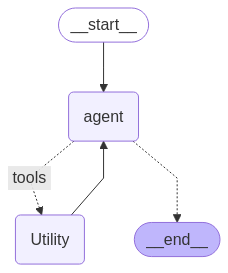

In [45]:

workflow01.add_node("agent", run_agent)
workflow01.add_node("Utility", agent_tool)


workflow01.set_entry_point("agent")


workflow01.add_conditional_edges(
    "agent",
    tools_condition ,
    {
        "tools": "Utility",
        END: END,

    },
)

workflow01.add_edge("Utility", "agent") 

graph01 = workflow01.compile(checkpointer=memory) 


from IPython.display import Image, display
try:
    display(Image(graph01.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [46]:
from langchain_core.messages import HumanMessage

while True:
    user_input = input("Your question: ")
    if user_input.lower() == "exit":
        break

    input_message = [HumanMessage(content=user_input)]
    config = {"configurable": {"session_id": "abc123", "thread_id": "abc123"}}

    for step in graph01.stream({"messages": input_message}, config=config, stream_mode="values"):
        if "messages" in step and step["messages"]:
            last_message = step["messages"][-1]
            if hasattr(last_message, "pretty_print"):
                last_message.pretty_print()
            else:
                print(last_message)

================================ Human Message =================================

My Resume:  Manjesh Prasad manjeshprasad21@gmail.com | (510) 209-8921| San Francisco, CA | github.com/Jay-tech456 | linkedin.com/in/manjesh-prasad  Professional Experience Full-Stack AI Software Engineer | Kismet XYZ | San Francisco, CA | February 2024 - Present • Engineered a Python-based real-time monitoring backend microservice queues for the company’s proprietary sensor data dashboard, providing real-time metrics and insights to natural gas well operators worldwide. • Collaborated with the hardware engineers, computer scientists, and executives to gather and implement the product requirements based on oil & gas user insights. Enhanced the company's data reporting capabilities, delivering more precise and actionable insights on pressure, temperature, flow rate, and moisture (H2O) metrics. Software Engineer | Glocal | Chicago, IL (Remote) | September 2023 - May 2024 • Worked with a cross-functional team

KeyboardInterrupt: 

In [ ]:
import os
import psycopg2
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()

# Connect to the database using the URL stored in the environment variable
conn = psycopg2.connect(os.getenv("DATABASE_URL"))
cursor = conn.cursor()
# Bellow is just a testing sequence
# # Run the query and fetch results
# with conn.cursor() as cur:
#     cur.execute("SELECT now()")
#     res = cur.fetchall()  # Retrieve all results
#     print(res)

# # Close the connection
# conn.close()


In [ ]:
import psycopg2
import os 
import dotenv 
dotenv.load_dotenv()
# Step 1: Connect to CockroachDB
connection = psycopg2.connect(
os.getenv("DATABASE_URL"),
)

cursor = connection.cursor()

# # Step 2: Create a new table
# cursor.execute(
#     """
#     DROP TABLE IF EXISTS candidates;
#     CREATE TABLE IF NOT EXISTS candidates (
#         candidate_id SERIAL PRIMARY KEY,
#         long_description TEXT
# );


#     """
# )

cursor.execute(
    """
    DROP TABLE IF EXISTS HRCandidates;

    CREATE TABLE IF NOT EXISTS HRCandidates (
        id SERIAL PRIMARY KEY,
        description TEXT NOT NULL, 
        timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        first_name VARCHAR(50) NOT NULL,
        last_name VARCHAR(50) NOT NULL
);

    

    """
)

# Step 3: Insert a new row
cursor.execute(
    """
    INSERT INTO HRCandidates (description, first_name, last_name)
    VALUES (%s, %s, %s)
    """,
    ('this is a test canidate','Manjesh', 'Prasad')
)

# # Save (commit) changes
connection.commit()

# Step 4: Query the table to confirm
cursor.execute("SELECT * FROM HRCandidates")
rows = cursor.fetchall()
print(rows)

# Step 5: Close connections
cursor.close()
connection.close()
